# Microbial trait database assembly

In [36]:
import pandas as pd
import numpy as np
import re
import upsetplot as ups
import matplotlib.pyplot as plt

## Importing data
- Using the ten largest databases: BacDive, Bergey's, Corkrey, FaProTax, IJSEM, JGI, Microbe Directory, Pasteur, Patric, and ProTraits

In [2]:
path = 'C:\\Users\\jenny\\Documents\\NTNU\\Master\\my_supplementary_data\\database\\'

bacdive_df = pd.read_csv(path+'prepared_data\\bacdive.csv', sep = ';')
bergeys_df = pd.read_csv(path+'prepared_data\\bergeys.csv', sep = ';')
corkrey_df = pd.read_csv(path+'prepared_data\\corkrey.csv', sep = ';')
faprotax_df = pd.read_csv(path+'prepared_data\\faprotax.csv', sep = ';')
ijsem_df = pd.read_csv(path+'prepared_data\\ijsem.csv', sep = ';')
jgi_df = pd.read_csv(path+'prepared_data\\jgi.csv', sep = ';')
microbedir_df = pd.read_csv(path+'prepared_data\\microbedir.csv', sep = ';')
pasteur_df = pd.read_csv(path+'prepared_data\\pasteur.csv', sep = ';')
patric_df = pd.read_csv(path+'prepared_data\\patric.csv', sep = ';')
protraits_df = pd.read_csv(path+'prepared_data\\protraits.csv', sep = ';')

db = [bacdive_df, bergeys_df, corkrey_df, faprotax_df, ijsem_df, jgi_df, microbedir_df, pasteur_df, patric_df, protraits_df]
names = ['bacdive', 'bergeys', 'corkrey', 'faprotax', 'ijsem', 'jgi', 'microbedir', 'pasteur', 'patric', 'protraits']

## Merging datasets

In [3]:
# standardising column names by removing prefixes (*dataset*_)
db_stnd = []
for d in db:
    cols = dict()
    for col in d:
        cols[col] = str(col).split('_')[1]
    db_stnd.append(d.rename(columns = cols))

In [4]:
# adding data sources to common dataframe 'merge'
# keys with source database names set as new index, transformed to column 'database' by resetting index
merge = pd.concat(db_stnd, keys = names)
merge.index.names = ['database','index']
merge = merge.reset_index().drop(columns = 'index').dropna(how = 'all')

### Creating comparable name columns for genus, species, strain, and full name (speciesStrain)


In [6]:
# removing taxonomic level indicators
def remove_tax(col):
    col = col.str.split()
    for i in col:
        if str(i) == 'nan': continue
        elif 'sp' in i: i.remove('sp')
        elif 'sp.' in i: i.remove('sp.')
        elif 'subsp' in i: i = i.remove('subsp')
        elif 'subsp.' in i: i = i.remove ('subsp.')
        elif 'str.' in i: i = i.remove('str.')
        elif 'str' in i: i = i.remove('str')
    col = col.fillna('')
    col = col.apply(lambda x:''.join([str(i) for i in x]))
    return col

merge['genusComp'] = remove_tax(merge['genus'])
merge['speciesComp'] = remove_tax(merge['species'])
merge['strainComp'] = remove_tax(merge['strain'])
merge['speciesStrainComp'] = remove_tax(merge['speciesStrain'])

# remove special characters (|!"#%&/()[]{}=+?'*-_.:,~^°) and set lowercase
def clean_name(s):
    if str(s).isalnum(): return s
    elif s == np.nan: return np.nan
    else: return re.sub('\!|\"|\#|\&|/|\(|\)|\[|\]|\=|\+|\?|\'|\*|\-|\_|\.|\,|\~|\^|\°|\:|\||\%','', s).lower()

merge['genusComp'] = merge['genusComp'].apply(lambda x:clean_name(x)).str.lower()
merge['speciesComp'] = merge['speciesComp'].apply(lambda x:clean_name(x)).str.lower()
merge['strainComp'] = merge['strainComp'].apply(lambda x:clean_name(x)).str.lower()
merge['speciesStrainComp'] = merge['speciesStrainComp'].apply(lambda x:clean_name(x)).str.lower()

# remove spaces
merge['genusComp'] = merge['genusComp'].str.replace(' ', '')
merge['speciesComp'] = merge['speciesComp'].str.replace(' ', '')
merge['strainComp'] = merge['strainComp'].str.replace(' ', '')
merge['speciesStrainComp'] = merge['speciesStrainComp'].str.replace(' ', '')

# reorganise columns and save
save = merge[['database','taxID','bacdiveID','speciesStrainComp','genusComp', 'speciesComp', 'strainComp','speciesStrain',
       'genus','species','strain','misclassified','cultureNo','typeStrain','gram','assays','oxygen','source','trophy',
       'substrate','medium','growthTemp','incubationDays','doublingH','metabolism','producedComp','pathogenicity',
       'reducedEnzAct','increasedEnzAct','variableEnzAct','extremophile','abSusceptible','genes','ref','genomeAccNo']]
save.to_csv(path+'assembledDataset.csv', sep = ';')

In [7]:
## check remaining special characters in speciesStrainComp
# have left ¥åð¡‰ and boxed ?

for r in range(0,len(merge)):
    if merge['speciesStrainComp'][r].isalnum(): continue
    else: print(merge.at[r,'speciesStrainComp'])

halomonasdenitri¥åcansm29t
ruaniaalbidi¥å‰ava36t
sul¥åtobacterlitoralisiso3t
thermovibrioammoni¥åcanshb1t
mycobacteriumtuberculosis0413ð
mycobacteriumtuberculosis1565ð¡


## CSV for plotting bar chart

In [9]:
# create columns with one database name per row
overview_df = pd.DataFrame(sorted(set(list(merge['database']))), columns = ['database'])

# columns to create, one for each data field in the merged dataset
cols = list(merge.drop('database', axis = 1).columns)

# for each column, insert the count of non-nan data points per dataset
for c in cols:
    overview_df[c] = pd.Series(int)
    for r in range(0,len(overview_df)):
        overview_df.loc[r, c] = int(merge[merge['database'] == overview_df['database'][r]][[c]].dropna().count()[0])

# add totals row
sums = ['total']
for c in overview_df.drop('database', axis = 1):
    sums.append(overview_df[c].sum())
overview_df.loc[len(overview_df)] = sums

# set database names as index
overview_df = overview_df.set_index('database')

# make CSV: sorting, dropping Comp columns,
overview_df = overview_df.sort_values('genus', ascending = False).T.sort_values('total', ascending = False).drop(['speciesStrainComp', 'strainComp', 'speciesComp', 'genusComp'], axis = 0)
overview_df.to_csv(path+'assembledDataset_fieldCoverage_raw.csv')

# replacing 0 with small number (1E-08) to allow log scaling
overview_df = overview_df.replace(0,0.00000001)
overview_df.to_csv(path+'assebmledDataset_fieldCoverage_plottable.csv')

# Plotting overlaps between data sources

In [10]:
# file with overlaps on genus-, species-, and strain-level coverage, and trait fields on strain-level
fieldCoverages = pd.read_csv(path + 'category_coverages.csv', sep = ';', low_memory = False).dropna(how = 'all')

In [11]:
# separating the field coverage file into one dataframe for each category
genusCoverage =  fieldCoverages[['genus', 'genusCoverage']].dropna().copy()
speciesCoverage = fieldCoverages[['species', 'speciesCoverage']].dropna().copy()
strainCoverage = fieldCoverages[['strainName', 'strainNameCoverage']].dropna().copy()
idCoverage = fieldCoverages[['strainName', 'IDCoverage']].dropna().copy()
cultureNoCoverage = fieldCoverages[['strainName', 'cultureNoCoverage']].dropna().copy()
typeStrainCoverage = fieldCoverages[['strainName', 'typeStrainCoverage']].dropna().copy()
assaysCoverage = fieldCoverages[['strainName', 'assaysCoverage']].dropna().copy()
gramCoverage = fieldCoverages[['strainName', 'gramCoverage']].dropna().copy()
sourceCoverage = fieldCoverages[['strainName', 'sourceCoverage']].dropna().copy()
mediumCoverage = fieldCoverages[['strainName', 'mediumCoverage']].dropna().copy()
growthTempCoverage = fieldCoverages[['strainName', 'growthTempCoverage']].dropna().copy()
doublingHCoverage = fieldCoverages[['strainName', 'doublingHCoverage']].dropna().copy()
oxygenCoverage = fieldCoverages[['strainName', 'oxygenCoverage']].dropna().copy()
trophyCoverage = fieldCoverages[['strainName', 'trophyCoverage']].dropna().copy()
substrateCoverage = fieldCoverages[['strainName', 'substrateCoverage']].dropna().copy()

### Genus-level overlap

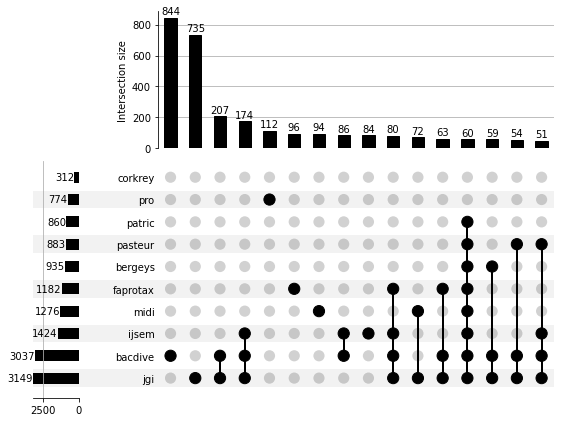

In [12]:
genusOverlap = ups.from_memberships(genusCoverage.genusCoverage.str.split(','), genusCoverage)
genusPlot = ups.UpSet(genusOverlap, min_subset_size = 50, show_counts = True, sort_by = 'cardinality').plot()

### Species-level overlap

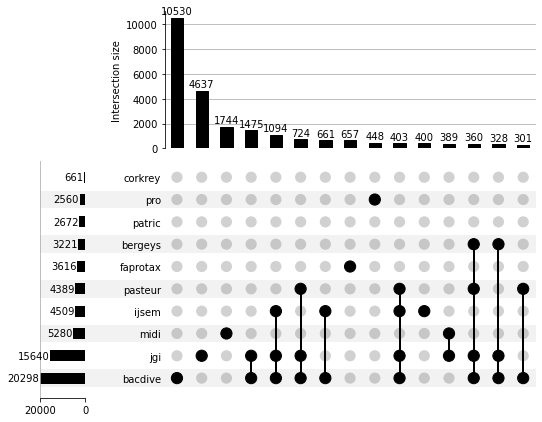

In [13]:
speciesOverlap = ups.from_memberships(speciesCoverage.speciesCoverage.str.split(','), speciesCoverage)
speciesPlot = ups.UpSet(speciesOverlap, min_subset_size = 250, show_counts = True, sort_by = 'cardinality').plot()

### Strain-level overlap

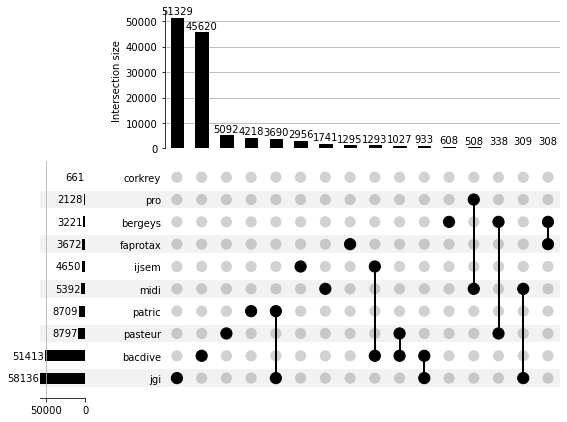

In [14]:
strainOverlap = ups.from_memberships(strainCoverage.strainNameCoverage.str.split(','), strainCoverage)
strainPlot = ups.UpSet(strainOverlap, min_subset_size = 300, show_counts = True, sort_by = 'cardinality').plot()

### Field: ID

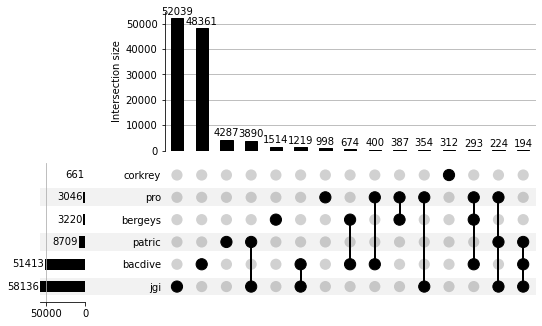

In [15]:
idOverlap = ups.from_memberships(idCoverage.IDCoverage.str.split(','), idCoverage)
idPlot = ups.UpSet(idOverlap, min_subset_size = 100, show_counts = True, sort_by = 'cardinality').plot()

### Field: Culture collection number

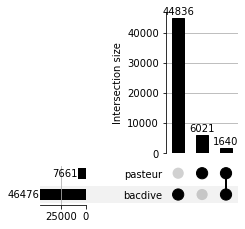

In [16]:
cultureNoOverlap = ups.from_memberships(cultureNoCoverage.cultureNoCoverage.str.split(','), cultureNoCoverage)
cultureNoPlot = ups.UpSet(cultureNoOverlap, min_subset_size = 0, show_counts = True, sort_by = 'cardinality').plot()

### Field: Type strain

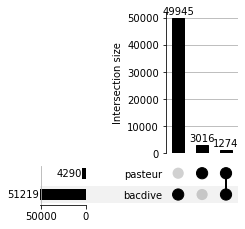

In [17]:
typeStrainOverlap = ups.from_memberships(typeStrainCoverage.typeStrainCoverage.str.split(','), typeStrainCoverage)
typeStrainPlot = ups.UpSet(typeStrainOverlap, min_subset_size = 0, show_counts = True, sort_by = 'cardinality').plot()

### Field: Assays

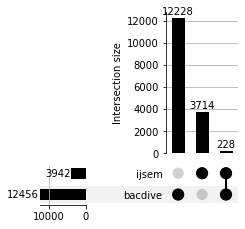

In [18]:
assaysOverlap = ups.from_memberships(assaysCoverage.assaysCoverage.str.split(','), assaysCoverage)
assaysPlot = ups.UpSet(assaysOverlap, min_subset_size = 100, show_counts = True, sort_by = 'cardinality').plot()

### Field: Gram stain

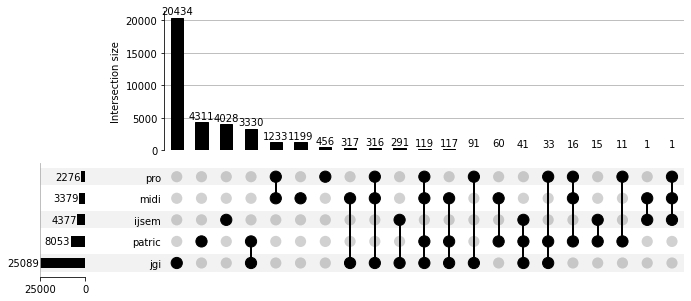

In [19]:
gramOverlap = ups.from_memberships(gramCoverage.gramCoverage.str.split(','), gramCoverage)
gramPlot = ups.UpSet(gramOverlap, min_subset_size = 0, show_counts = True, sort_by = 'cardinality').plot()

### Field: Source

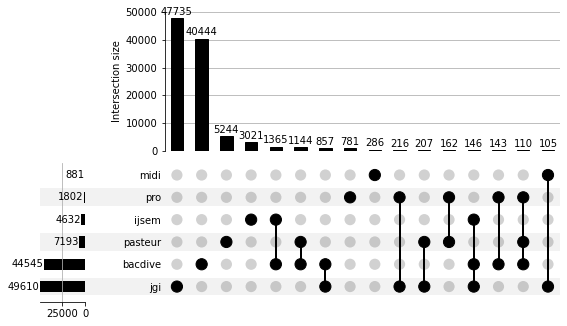

In [20]:
sourceOverlap = ups.from_memberships(sourceCoverage.sourceCoverage.str.split(','), sourceCoverage)
sourcePlot = ups.UpSet(sourceOverlap, min_subset_size = 100, show_counts = True, sort_by = 'cardinality').plot()

### Field: Medium

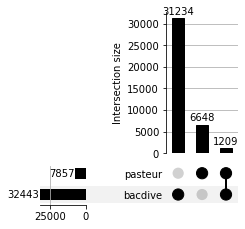

In [21]:
mediumOverlap = ups.from_memberships(mediumCoverage.mediumCoverage.str.split(','), mediumCoverage)
mediumPlot = ups.UpSet(mediumOverlap, min_subset_size = 0, show_counts = True, sort_by = 'cardinality').plot()

### Field: Growth temperature

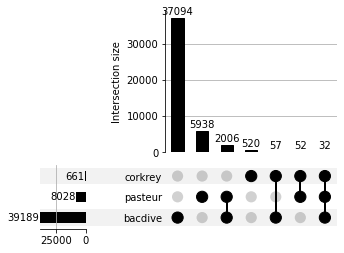

In [22]:
growthTempOverlap = ups.from_memberships(growthTempCoverage.growthTempCoverage.str.split(','), growthTempCoverage)
growthTempPlot = ups.UpSet(growthTempOverlap, min_subset_size = 0, show_counts = True, sort_by = 'cardinality').plot()

### Field: Doubling time (hours)

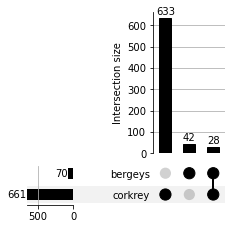

In [23]:
doublingHOverlap = ups.from_memberships(doublingHCoverage.doublingHCoverage.str.split(','), doublingHCoverage)
doublingHPlot = ups.UpSet(doublingHOverlap, min_subset_size = 0, show_counts = True, sort_by = 'cardinality').plot()

### Field: Oxygen requirement

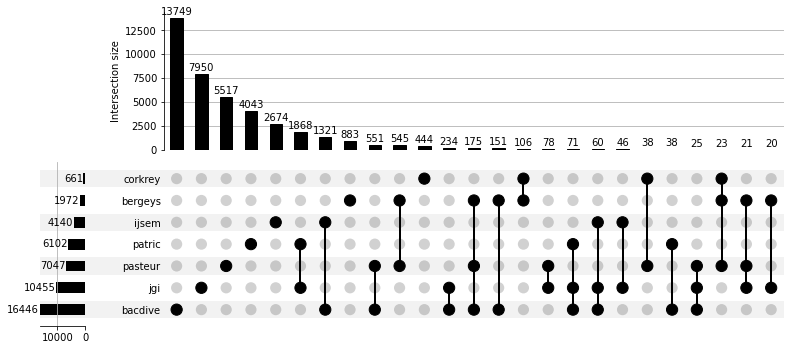

In [24]:
oxygenOverlap = ups.from_memberships(oxygenCoverage.oxygenCoverage.str.split(','), oxygenCoverage)
oxygenPlot = ups.UpSet(oxygenOverlap, min_subset_size = 20, show_counts = True, sort_by = 'cardinality').plot()

### Field: Trophy

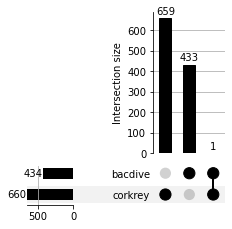

In [25]:
trophyOverlap = ups.from_memberships(trophyCoverage.trophyCoverage.str.split(','), trophyCoverage)
trophyPlot = ups.UpSet(trophyOverlap, min_subset_size = 0, show_counts = True, sort_by = 'cardinality').plot()

### Field: Substrate

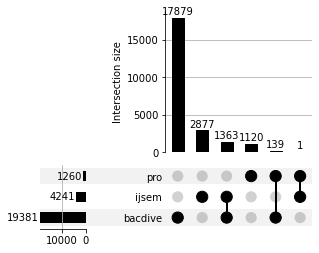

In [31]:
substrateOverlap = ups.from_memberships(substrateCoverage.substrateCoverage.str.split(','), substrateCoverage)
substratePlot = ups.UpSet(substrateOverlap, min_subset_size = 0, show_counts = True, sort_by = 'cardinality').plot()